# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



**1.**

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./data/airbnb_hw.csv')
df = df.dropna()

price = df['Price']
price = price.str.replace(',','')
price = pd.to_numeric(price,errors='coerce')
df['Price'] = price
del price
df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0
5,1039,7/25/2008,Big Greenpoint 1BD w/ Skyline View,Brooklyn,Apartment,100.0,Entire home/apt,11222.0,1.0,1,4,149,100.0
6,1783,8/12/2008,Amazing Also,Manhattan,Apartment,100.0,Entire home/apt,10004.0,1.0,1,9,250,100.0
7,2078,8/15/2008,"Colorful, quiet, & near the subway!",Brooklyn,Apartment,90.0,Private room,11201.0,1.0,1,80,90,94.0
8,2339,8/20/2008,East Village Cocoon: 2 Bedroom Flat,Manhattan,Apartment,90.0,Entire home/apt,10009.0,2.0,1,95,270,90.0


In [3]:
df.columns

Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood ', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating'],
      dtype='object')

<Axes: xlabel='Price', ylabel='Count'>

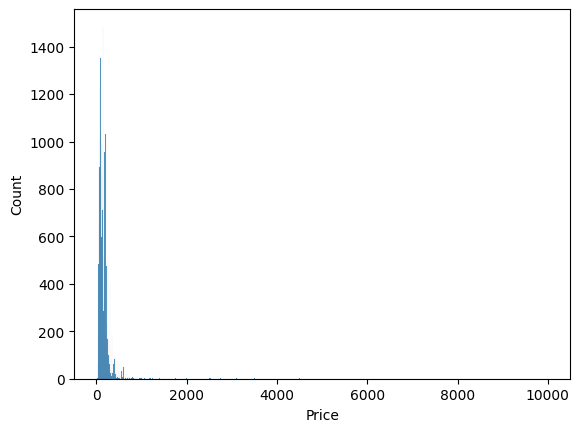

In [4]:
import seaborn as sns
sns.histplot(data=df,x='Price')

<Axes: xlabel='Price_log', ylabel='Count'>

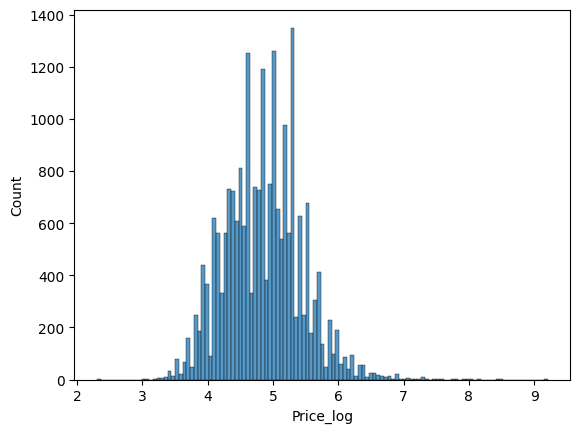

In [5]:
df['Price_log'] = np.log(df['Price'])
sns.histplot(data=df,x='Price_log')

**2.**

In [23]:
df['Age'] = 2024 - pd.to_datetime(df['Host Since']).dt.year
selected_features = [
    'Property Type', 'Room Type', 'Beds', 'Number Of Reviews',
    'Review Scores Rating', 'Age'
]
X = df[selected_features]
y = df['Price']

X = pd.get_dummies(X, drop_first=True)


**3.**

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**4.**

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

room_type_dummies = pd.get_dummies(df['Room Type'], drop_first=True)
X_train_rt, X_test_rt = room_type_dummies.loc[X_train.index], room_type_dummies.loc[X_test.index]

simple_model_1 = LinearRegression().fit(X_train_rt, y_train)
y_pred_1 = simple_model_1.predict(X_test_rt)

rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred_1))
r2_1 = r2_score(y_test, y_pred_1)
print("Model 1 - Room Type Only")
print(f"RMSE: {rmse_1}")
print(f"R²: {r2_1}")


Model 1 - Room Type Only
RMSE: 126.19267197459138
R²: 0.16875723265688936


In [26]:
X_train_beds_reviews = X_train[['Beds', 'Number Of Reviews']]
X_test_beds_reviews = X_test[['Beds', 'Number Of Reviews']]

simple_model_2 = LinearRegression().fit(X_train_beds_reviews, y_train)
y_pred_2 = simple_model_2.predict(X_test_beds_reviews)

rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_2))
r2_2 = r2_score(y_test, y_pred_2)
print("Model 2 - Beds and Number of Reviews Only")
print(f"RMSE: {rmse_2}")
print(f"R²: {r2_2}")


Model 2 - Beds and Number of Reviews Only
RMSE: 125.27047485837369
R²: 0.18086203530265343


The second model performs better

**5.**

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_train_complex = X_train.copy()
X_test_complex = X_test.copy()

X_train_complex['log_beds'] = np.log1p(X_train['Beds'])
X_test_complex['log_beds'] = np.log1p(X_test['Beds'])

X_train_complex['sqrt_reviews'] = np.sqrt(X_train['Number Of Reviews'])
X_test_complex['sqrt_reviews'] = np.sqrt(X_test['Number Of Reviews'])

X_train_complex['beds_reviews'] = X_train['Beds'] * X_train['Number Of Reviews']
X_test_complex['beds_reviews'] = X_test['Beds'] * X_test['Number Of Reviews']

X_train_complex['rating_age'] = X_train['Review Scores Rating'] * X_train['Age']
X_test_complex['rating_age'] = X_test['Review Scores Rating'] * X_test['Age']

complex_model = LinearRegression()
complex_model.fit(X_train_complex, y_train)

y_train_pred_complex = complex_model.predict(X_train_complex)
y_test_pred_complex = complex_model.predict(X_test_complex)

train_rmse_complex = np.sqrt(mean_squared_error(y_train, y_train_pred_complex))
test_rmse_complex = np.sqrt(mean_squared_error(y_test, y_test_pred_complex))
train_r2_complex = r2_score(y_train, y_train_pred_complex)
test_r2_complex = r2_score(y_test, y_test_pred_complex)

print(f"Training RMSE: {train_rmse_complex}")
print(f"Training R²: {train_r2_complex}")
print(f"Testing RMSE: {test_rmse_complex}")
print(f"Testing R²: {test_r2_complex}")


Training RMSE: 133.9999163811696
Training R²: 0.21783963034117415
Testing RMSE: 117.50257394830253
Testing R²: 0.27930025633988864


The more complex model performs better

**6.** The analysis of different models in predicting Airbnb prices showed th importance of balancing model simplicity and complexity. Initial simple models using only a few features like Room Type or Beds and Number of Reviews showed low predictive power underfitting the data and captured only a small fraction of the variation in prices. Introducing a more complex model with manually engineered features such as log transformations and interaction terms improved performance significantly as shown by the higher R² values. These engineered features helped capture non linear relationships and interactions between predictors without adding excessive complexity thereby avoiding overfitting. The progression highlights a that simple models may fail to capture essential relationships while carefully constructed complex models can achieve a balance between accuracy and generalization. The best performing model in this case used  transformations and interactions, making it  interpretable and relatively more effective in predicting prices.

**7. (Optional, skipped)**